In [1]:
%config IPCompleter.greedy=True

In [2]:
import os
print(os.listdir("../input"))

['flower-species', 'flowerjsonmap']


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using the flower dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

After completion of this project, we'll have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application.Other examples are we can imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it.


In [3]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import seaborn as sb
#import workspace_utils
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from os import listdir
from collections import OrderedDict
import helper

## Load the data

Here 'torchvision' is used to load the data.(http://pytorch.org/docs/0.3.0/torchvision/index.html)).                  The dataset is split into three parts, training, validation, and testing. For the training, we'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this any scaling or rotation transformations are not needed, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = '../input/flower-species/flower_data/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_image_datasets = datasets.ImageFolder(valid_dir, transform=test_data_transforms)
test_image_datasets = datasets.ImageFolder(test_dir, transform=test_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=128)
valid_dataloaders = torch.utils.data.DataLoader(valid_image_datasets, batch_size=128)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=64)

In [6]:
"""data_iter = iter(train_dataloaders)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)"""

'data_iter = iter(train_dataloaders)\n\nimages, labels = next(data_iter)\nfig, axes = plt.subplots(figsize=(10,4), ncols=4)\nfor ii in range(4):\n    ax = axes[ii]\n    helper.imshow(images[ii], ax=ax)'

### Label mapping

We have loaded in a mapping from category label to category name. You can find this in the file `cat_to_name.json` which has been imported. It's a JSON object which you can read in with the `json` module . This will give a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('../input/flowerjsonmap/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, we'll build and train the classifier. We have used one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

The procedure is as follows:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (For example,the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make we have updated only the weights of the feed-forward network. Our goal is to be able to get the validation accuracy above 70%. To increase the efficiency we'll try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use if required for further procedures.


In [8]:
model = models.vgg16(pretrained=True)
#!wget http://download.pytorch.org/models/vgg19-dcbb9e9d.pth
#!mv vgg19-dcbb9e9d.pth ~/.torch/models/
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.torch/models/vgg16-397923af.pth
553433881it [00:07, 72852756.71it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
# TODO: Building the network
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 10000)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.3)),
                          ('fc2', nn.Linear(10000, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.3)),
                          ('fc3', nn.Linear(4096, 1024 )),
                          ('relu', nn.ReLU()),
                          ('fc4', nn.Linear(1024, 102)),   
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [10]:
#Training my network by defining the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.00001)

In [11]:
def validation(model, valid_dataloaders, criterion):
    model.to('cuda')
    test_loss = 0
    accuracy = 0
    for images, labels in valid_dataloaders:

        #images.resize_(images.shape[0],3, 224, 224)
        images, labels = images.to('cuda'), labels.to('cuda')
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.cuda.FloatTensor).mean()
    
    return test_loss, accuracy
#print(images.shape[0])


In [12]:
#from workspace_utils import active_session

epochs = 25
print_every = 40
steps = 0
running_loss = 0
    #change to cuda
model.to('cuda')

for e in range(epochs):
    model.train()
    for ii, (images, labels) in enumerate(train_dataloaders):
        steps += 1

        images, labels = images.to('cuda'), labels.to('cuda')

                #images.resize_(images.size()[0],3,224,224)#flattening the images

        optimizer.zero_grad()

        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:

            model.eval()# Make sure network is in eval mode for inference

            with torch.no_grad(): # Turn off gradients for validation, saves memory and computations
                test_loss, accuracy = validation(model, valid_dataloaders, criterion)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(valid_dataloaders)),
                  "Test Accuracy: {:.3f}".format((accuracy/len(valid_dataloaders))*100))

            running_loss = 0

                    # Make sure training is back on
            model.train()

Epoch: 1/25..  Training Loss: 4.865..  Test Loss: 4.493..  Test Accuracy: 6.920
Epoch: 2/25..  Training Loss: 4.652..  Test Loss: 4.283..  Test Accuracy: 13.183
Epoch: 3/25..  Training Loss: 4.457..  Test Loss: 4.075..  Test Accuracy: 18.259
Epoch: 4/25..  Training Loss: 4.261..  Test Loss: 3.805..  Test Accuracy: 18.022
Epoch: 4/25..  Training Loss: 4.090..  Test Loss: 3.525..  Test Accuracy: 24.768
Epoch: 5/25..  Training Loss: 3.935..  Test Loss: 3.190..  Test Accuracy: 31.143
Epoch: 6/25..  Training Loss: 3.545..  Test Loss: 2.806..  Test Accuracy: 41.661
Epoch: 7/25..  Training Loss: 3.301..  Test Loss: 2.453..  Test Accuracy: 49.054
Epoch: 7/25..  Training Loss: 2.975..  Test Loss: 2.221..  Test Accuracy: 51.951
Epoch: 8/25..  Training Loss: 2.825..  Test Loss: 1.947..  Test Accuracy: 55.996
Epoch: 9/25..  Training Loss: 2.568..  Test Loss: 1.686..  Test Accuracy: 64.357
Epoch: 10/25..  Training Loss: 2.256..  Test Loss: 1.500..  Test Accuracy: 71.929
Epoch: 10/25..  Training Los

## Testing your network

We'll test our trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way to be dione for validation. A minimum of 70% accuracy on the test set is to be gained if the model has been trained well.

In [13]:
# TODO: Do validation on the test set
correct = 0
total = 0
model.to('cuda')
with torch.no_grad():
    for images,labels in test_dataloaders:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images).to('cuda')
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 86 %


## Save the checkpoint

After the network is trained, save the model so we can load it later for making predictions. We will also save the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

We have to completely rebuild the model later so to use it for inference. We have made sure to include any information needed in the checkpoint. If we want to load the model and keep training, we have to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. We can use this trained model in the future for further use.

In [14]:
# TODO: Save the checkpoint
#Changing after the review
model.class_to_idx = train_image_datasets.class_to_idx
checkpoint = {'input_size':25088,
              'output_size':102,
              'arch':'vgg16',
              'learning_rate':0.00001,
              'classifier':classifier,
              'state_dict': model.state_dict(),
              'class_idx': model.class_to_idx,
              #'optimizer_state':optimizer.state_dict,
              'epochs':15,
              }

torch.save(checkpoint, '../checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    learn_rate= checkpoint['learning_rate']
    epochs = checkpoint['epochs']
    
    model.classifier = checkpoint['classifier']
    
    model.class_to_idx = checkpoint['class_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [16]:
model = load_checkpoint('../checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Here, we have defined a function which uses a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. The function called `predict` will take an image and a model, then will return the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

But before that, we have to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

We'll use `PIL` to load the image. This function preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the `thumbnail` or 'resize' methods. After that we'll crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll convert the values. It's easiest with a Numpy array, which we can get from a PIL image like this `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 


In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    image_process = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
    
    np_image = image_process(img)
    return np_image

In [18]:
# TODO: Process a PIL image for use in a PyTorch model
image_path = (data_dir + '/test' + '/11/' + 'image_03115.jpg')
img = process_image(image_path)

To cross_check `process_image` function, the `imshow` function is defined which converts a PyTorch tensor and displays it in the notebook. If `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [19]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

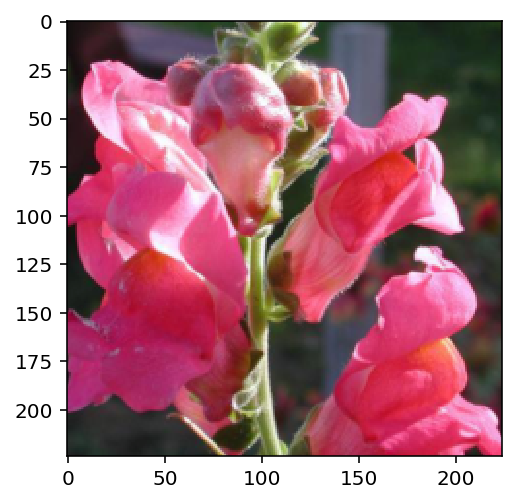

In [20]:
image_path = ("../input/flower-species/flower_data/flower_data/test/11/image_03130.jpg")
process_image(image_path)
imshow(process_image(image_path))

## Class Prediction

Once we get images in the correct format, we define a function for making predictions with the trained model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use `x.topk(k)`. This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. 

The we'll convert from these indices to the actual class labels using `class_to_idx` which we have added to the model used to load the data. We'll invert the dictionary to get a mapping from index to class as well.

This method should take a path to an image and a model checkpoint, then return the probabilities and classes as shown here:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [21]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    ''' 
    model.to('cuda')
    image = process_image(image_path)
    # TODO: Implement the code to predict the class from an image file
    image.unsqueeze_(0)
    outputs = model(image.to('cuda'))
    probs = torch.exp(outputs)
    top_probs, top_labs = probs.topk(topk, dim=1)
    top_probs, top_labs = top_probs.cpu(), top_labs.cpu()
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labs = top_labs.detach().numpy().tolist()[0]
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labs, top_flowers

In [22]:
image_path = (data_dir + '/test' + '/11/' + 'image_03130.jpg')
probs, classes, flowers = predict(image_path, model)
print(probs)
print(classes)

[0.5734936594963074, 0.1298559606075287, 0.06236817315220833, 0.028913503512740135, 0.028637638315558434]
[5, 96, 36, 74, 72]


## Result Checking

Now after the trained model is ready for making predictions, we'll check to get some good results.We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

We'll convert from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, we'll use the `imshow` function defined above.

In [23]:
# TODO: Display an image along with the top 5 classes
def sanity_check(image_path, model):
    
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    flower_num = image_path.split('/')[6]
    flower_title_ = cat_to_name[flower_num]

    image = process_image(image_path)
    imshow(image, ax, title = flower_title_)
    
    probs, labs, flowers = predict(image_path, model)        #to make prediction and plot a bar graph for top 5
                                                            
    plt.subplot(2,1,2)
    color_palette = sb.color_palette()[0];
    sb.barplot(x=probs, y=flowers, color = color_palette);
    plt.show()

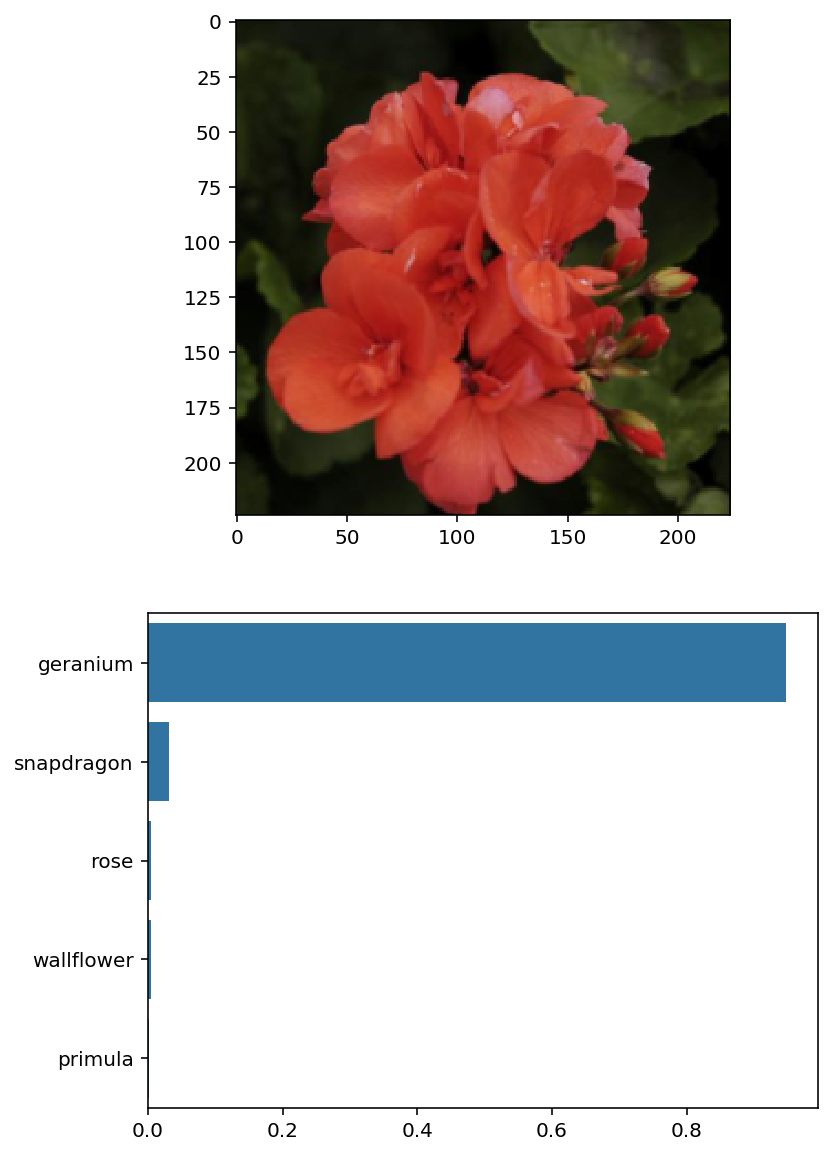

In [24]:
sanity_check('../input/flower-species/flower_data/flower_data/test/58/image_02719.jpg', model)

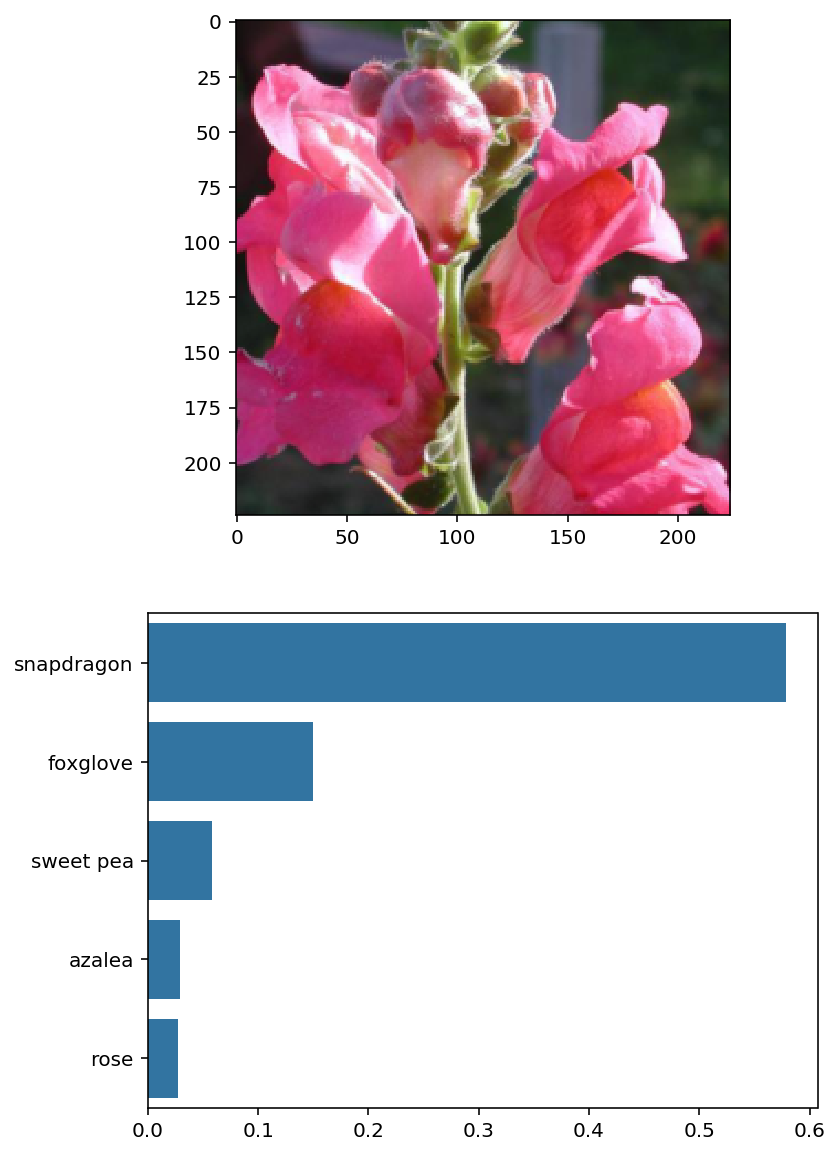

In [25]:
sanity_check('../input/flower-species/flower_data/flower_data/test/11/image_03130.jpg', model)

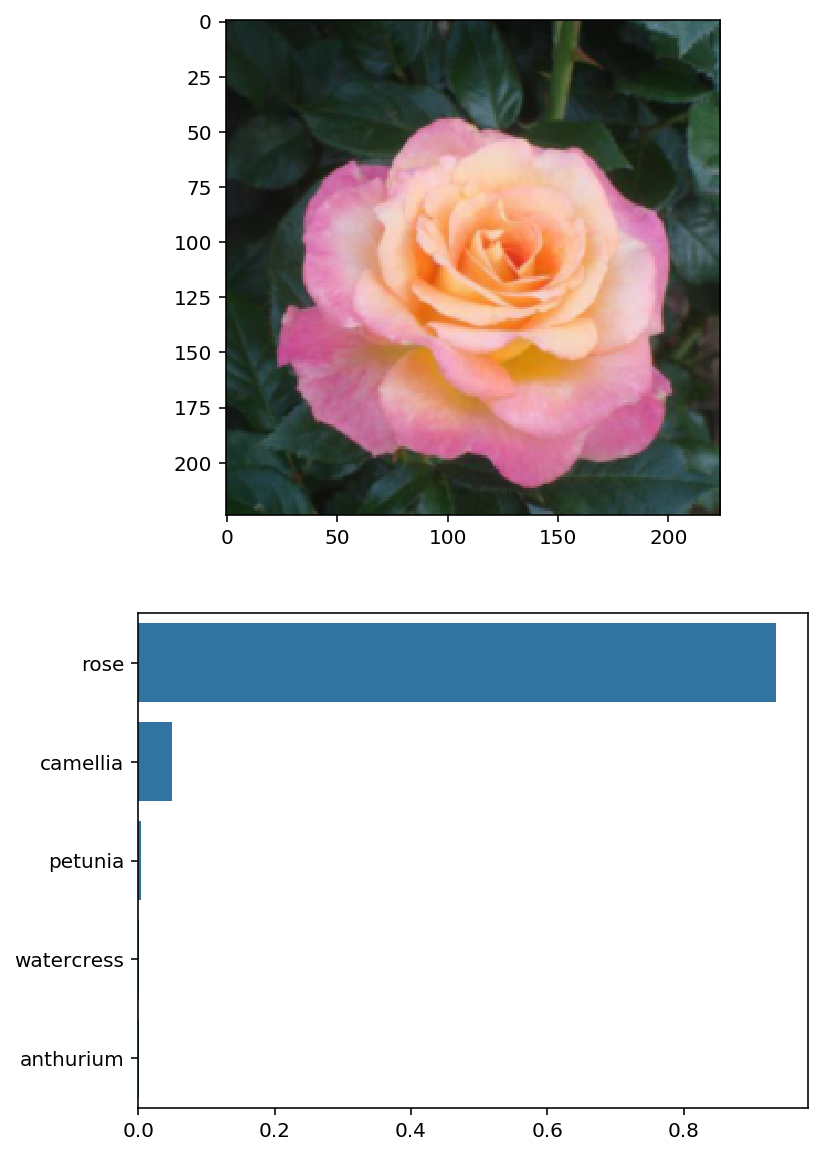

In [26]:
sanity_check('../input/flower-species/flower_data/flower_data/test/74/image_01254.jpg', model)

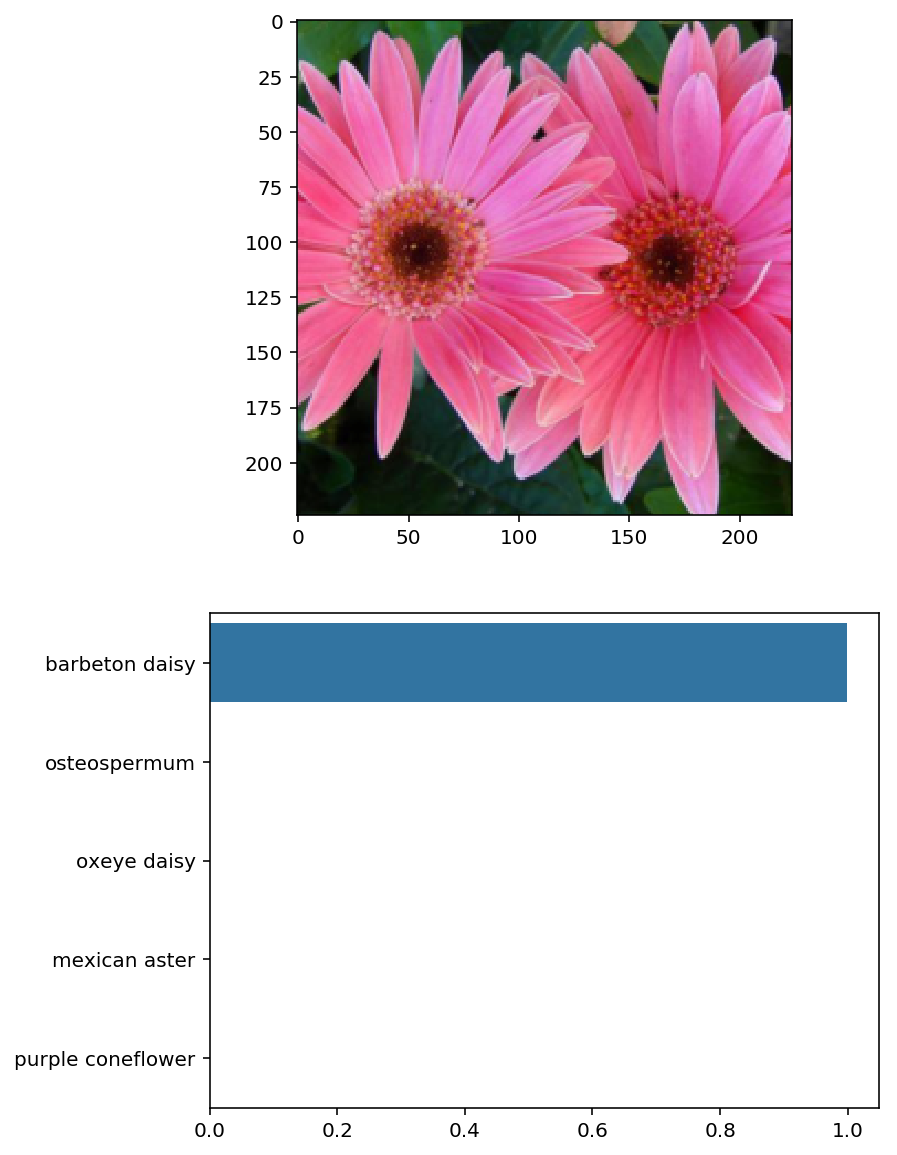

In [27]:
sanity_check('../input/flower-species/flower_data/flower_data/test/41/image_02257.jpg', model)